## Семинар 4: "Сверточные сети"


In [1]:
import numpy as np
#from sklearn.datasets import fetch_mldata
#from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка


#### Одномерные сигналы

Начнем с одномерных сигналов — например, это могут быть различные временные ряды.


<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>


In [2]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal) - len(kernel) + 1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е.
    #   размер результирующего сигнала должен быть меньше входного.

    for i in range(signal_convolved.shape[0]):

        signal_convolved[i] = np.sum(signal[i : i + kernel.shape[0]] * kernel[::-1])

    return signal_convolved


Проверим правильность реализации, сравнив с реализацией из scipy


In [3]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode="valid")

np.testing.assert_allclose(t_result, b_result)


In [4]:
b_result = convolve(signal, kernel, mode="same")
b_result.shape


(100,)

In [5]:
b_result.shape


(100,)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала


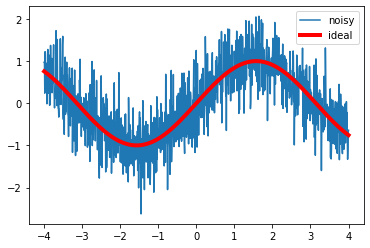

In [6]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0]) * 0.5
plt.plot(x, noisy_signal, label="noisy")
plt.plot(x, signal, "r", label="ideal", linewidth=4)
plt.legend(loc=0)


Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.


<i>1.2 Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>


In [14]:
kernel_size = 56
kernel = np.ones(kernel_size) / kernel_size

denoised_signal = convolve(noisy_signal, kernel, "same")


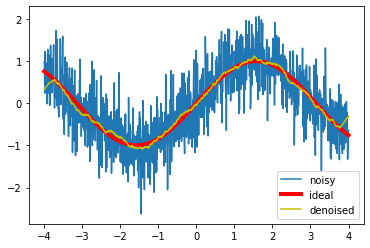

In [15]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label="noisy")
plt.plot(x, signal, "r", label="ideal", linewidth=4)
plt.plot(x, denoised_signal, "y", label="denoised")
plt.legend(loc=0)


Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.


<i> 1.3 Подберите размер окна <i>


In [13]:
from tqdm import tqdm

error_min = None
ks_min = None

for kernel_size in tqdm(range(1, 1000)):

    kernel = np.ones(kernel_size) / kernel_size

    denoised_signal = convolve(noisy_signal, kernel, "same")
    error = np.array((signal - denoised_signal) ** 2).mean()
    if error_min is None or error < error_min:
        error_min = error
        ks_min = kernel_size


print(f"Best kernel size: {ks_min}, error: {error_min}")


100%|██████████| 999/999 [00:00<00:00, 3871.27it/s]

Best kernel size: 56, error: 0.007283895050837423


#### Многомерные сигналы

Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).


Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>


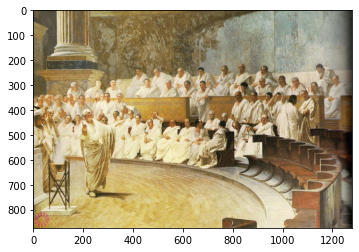

In [17]:
image = plt.imread("./image.jpg")
plt.imshow(image)


<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>


In [24]:
color_to_bw = np.array([0.2126, 0.7152, 0.0722])


<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>


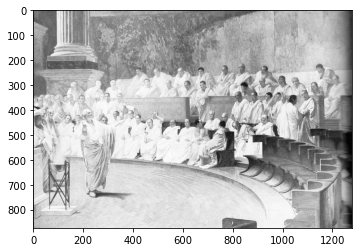

In [25]:
from scipy.signal import convolve2d

bw_image = convolve(image.flatten(), color_to_bw, "same")[::3].reshape(image.shape[:2])
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)


Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.


<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>


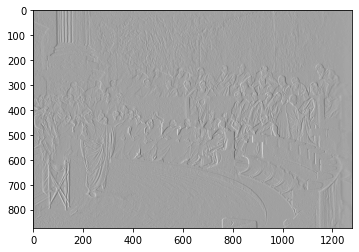

In [26]:
from scipy.signal import convolve2d

kernel_y = np.array(
    [
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1],
    ]
)

res_y = convolve2d(bw_image, kernel_y, "same")
res_x = convolve2d(bw_image, kernel_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)


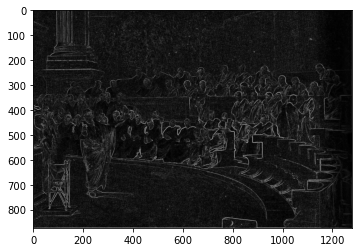

In [27]:
res_x_y = (res_x**2 + res_y**2) ** 0.5
plt.imshow(res_x_y, cmap=plt.cm.Greys_r)


В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.


<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>


In [28]:
# 10 x 10 x 3
# 10 x 10 x d

# 3 x 1 x 1 x d


def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    assert signal.shape[-1] == kernel.shape[0]

    output = np.zeros(signal.shape[:2] + (kernel.shape[-1],))

    for i in range(kernel.shape[-1]):
        for j in range(signal.shape[-1]):

            output[:, :, i] += convolve2d(signal[:, :, j], kernel[j, :, :, i], "same")

    return output


<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>


In [30]:
kernel = np.array(
    [
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
    ]
).reshape(3, 1, 1, 3)


<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>


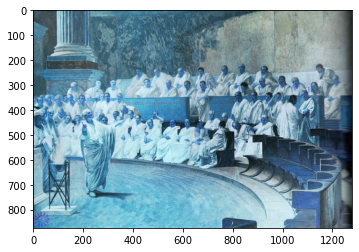

In [31]:
# Не забудьте, что после свертки вы скорее всего получите тензор типа float.
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))


image_bgr = t_convolve_bank(image, kernel)
plt.imshow(image_bgr.astype("uint8"))


В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).


### Часть 2: Пулинг


При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.


<i>2.1 Реализуйте операции пулинга для цветных изображений</i>


In [32]:
def pooling(image, w=2, func=np.max):
    assert image.ndim == 3

    output = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))

    for i in range(0, image.shape[0] - w, w):
        for j in range(0, image.shape[1] - w, w):
            output[i // w, j // w, :] = func(
                image[i : i + w, j : j + w, :], axis=(0, 1)
            )
    return output


def maxpool(image, w=2):
    assert image.ndim == 3

    return pooling(image, w=w, func=np.max)


def medianpool(image, w=2):
    assert image.ndim == 3

    return pooling(image, w=w, func=np.median)


Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.


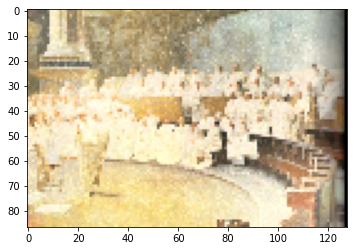

In [35]:
maxpool_image = maxpool(image, 10)
plt.imshow(maxpool_image.astype("uint8"))


<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>


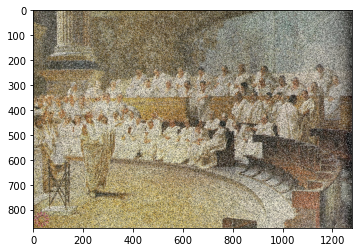

In [40]:
image_salt_pepper = image.copy()

p = 0.8

ind_white = np.random.rand(*image.shape[:2]) > p
ind_black = np.random.rand(*image.shape[:2]) > p

image_salt_pepper[ind_white] = (255, 255, 255)
image_salt_pepper[ind_black] = (0, 0, 0)

plt.imshow(image_salt_pepper.astype("uint8"))


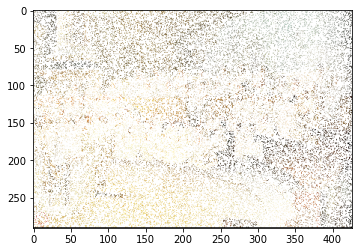

In [43]:
maxpool_image = maxpool(image_salt_pepper, 3)
plt.imshow(maxpool_image.astype("uint8"))


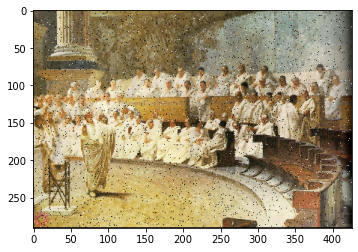

In [44]:
medianpool_image = medianpool(image_salt_pepper, 3)
plt.imshow(medianpool_image.astype("uint8"))


<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>


Медианный, т.к. в максимальном очевидно какой пиксель в окне "главный", т.е. от исходного изображения останутся только те пиксели, в окрестности которых не было таких шумов


### Часть 3: Сверточная сеть на pyTorch


pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.


Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры:

1. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
2. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>


In [98]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(101)


In [106]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
train_dataset = MNIST(".", train=True, download=True, transform=transform)
test_dataset = MNIST(".", train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [107]:
image_size = 28
channels = 1


class ConvClassifier(nn.Module):
    def __init__(self, image_size, arch_type="1"):
        super().__init__()

        self.pipeline = (
            nn.Sequential(
                nn.Conv2d(channels, 8, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(8, 16, 3, padding=1),
                nn.ReLU(),
                nn.Flatten(1),
                nn.Linear(image_size // 2 * image_size // 2 * 16, 10),
                nn.LogSoftmax(dim=1),
            )
            if arch_type == "1"
            else nn.Sequential(
                nn.Conv2d(channels, 8, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(8, 16, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(16, 32, 3, padding=1),
                nn.Flatten(1),
                nn.Linear(image_size // 2 * image_size // 2 * 32, 10),
                nn.LogSoftmax(dim=1),
            )
        )

    def forward(self, x):
        x = self.pipeline(x)
        return x


In [108]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append(
                    (np.argmax(prediction.data.numpy(), 1) == y.data.numpy()).mean()
                )
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append(
                    (np.argmax(prediction.data.numpy(), 1) == y.data.numpy()).mean()
                )
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print(
                "\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}".format(
                    epoch,
                    train_loss_epochs[-1],
                    test_loss_epochs[-1],
                    train_accuracy_epochs[-1],
                    test_accuracy_epochs[-1],
                )
            )
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label="Train")
            plt.plot(test_loss_epochs, label="Test")
            plt.xlabel("Epochs", fontsize=16)
            plt.ylabel("Loss", fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label="Train accuracy")
            plt.plot(test_accuracy_epochs, label="Test accuracy")
            plt.xlabel("Epochs", fontsize=16)
            plt.ylabel("Loss", fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass


<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>


Epoch 4... (Train/Test) NLL: 0.104/0.088	Accuracy: 0.970/0.974


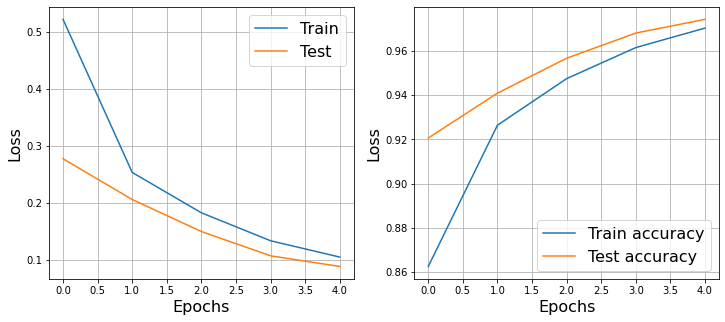

In [109]:
network = ConvClassifier(image_size=28, arch_type="1")
train(network, 5, 1e-4)


Epoch 4... (Train/Test) NLL: 0.056/0.049	Accuracy: 0.983/0.985


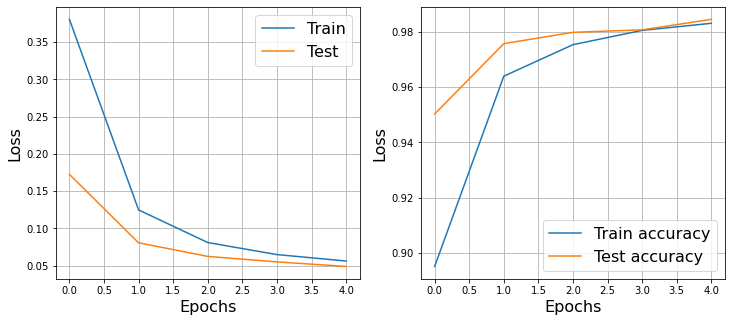

In [110]:
network = ConvClassifier(image_size=28, arch_type="2")
train(network, 5, 1e-4)


0.985 на тесте у второй архитектуры, полносвязная на аугментации вращениями давала 96.95


<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>


In [114]:
pictures = []
labels = []

for batch, target in test_loader:
    y_pred = network(batch)
    y_pred = y_pred.argmax(axis=1)
    for i in range(batch.shape[0]):
        if y_pred[i] != target[i]:
            pictures.append(batch[i])
            labels.append(f"predicted: {y_pred[i]} / target: {target[i]}")
            if len(pictures) > 25:
                break
            

predicted: 5 / target: 9


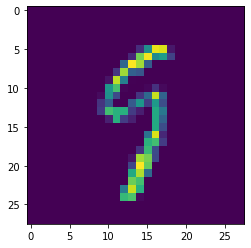

In [119]:
i = 29
print(labels[i])
plt.imshow(pictures[i].reshape(28, 28))


<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>


In [122]:
# накинем вращения на трейн
train_dataset = MNIST(
    ".",
    train=True,
    transform=transforms.Compose(
        [
            transforms.RandomRotation(degrees=(-15, 15)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)
test_dataset = MNIST(
    ".",
    train=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [123]:
# а в модельку закинем ещё один линейный слой
class MyConvClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        self.pipeline = nn.Sequential(
            nn.Conv2d(channels, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.Flatten(1),
            nn.Linear(image_size // 2 * image_size // 2 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = self.pipeline(x)
        return x


Epoch 4... (Train/Test) NLL: 0.046/0.029	Accuracy: 0.985/0.989


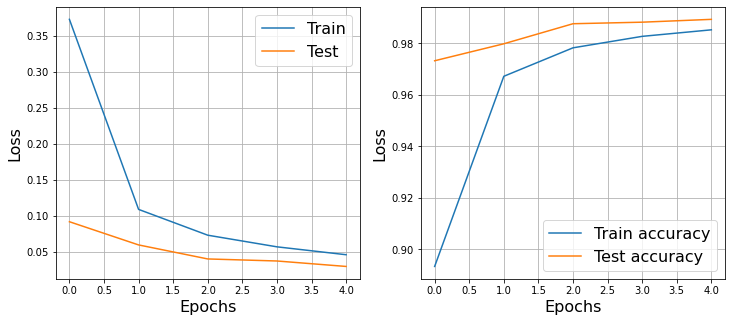

In [124]:
network = MyConvClassifier(image_size=28)
train(network, 5, 1e-4)


стало лучше 0.985 -> 0.989


#### Feedback (опционально)


Здесь вы можете оставить список опечаток из лекции или семинара:


Здесь вы можете оставить комментарии по лекции или семинару:
